<a href="https://colab.research.google.com/github/SeanNassimiha/ML-for-Physicists-PHAS0056/blob/main/PCA_and_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 - PCA and MNIST

## Sean Nassimiha

In this notebook, we will create a neural network to perform the task of MNIST digits recognition. This will be done initially in the conventional way, but then we will use Principal Component Analysis (PCA) to decompose the images in their principal components, and then train the neural network on images that contained only the first n components. We will then plot a  curve for Accuracy vs N components of the performance of the neural network on the test dataset. 

We will start by importing the usual modules, including the linalg module for performing PCA. 

In [1]:
#importing matplotlib and related modules
import matplotlib.pyplot as plt
import matplotlib as mpl

#importing numpy and the time function for measuring training/evaluating time
import numpy as np
import time

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#importing linear algebra modules
from scipy import linalg

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch
plt.style.use('ggplot') #choosing plot styles

#Useful for debugging problems
print(tf.__version__)

2.3.0


In [2]:
mnist = keras.datasets.mnist   #Uploading the MNIST database

(train_images, train_labels), (test_images, test_labels) = mnist.load_data() #load the data

#reshape the data into pictures that can be used as an input for a CNN
train_images = train_images.reshape((train_images.shape[0], 28,28,1))
test_images = test_images.reshape((test_images.shape[0], 28,28,1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
#Using MNIST CNN architecture similar to what was developed last week
def MNIST_NN(train_images, epochs):
    """
    Function that creates the model architecture, compiles, 
    and then trains on the specific input data, on a chosen epochs number
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1))) #convolutional layer
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu')) #dense layer
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(10)) #output layer

    #compiling and training the CNN to the data
    model.compile(optimizer='adam', 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=epochs, 
                        validation_data=(test_images, test_labels), verbose=0)
    
    return history, model

# training the model
history, model = MNIST_NN(train_images, 2)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.0353 - accuracy: 0.9887


 As it can be seen, this network achieves a performance of 98.65% on only two epochs. We will at this point use linear algebra to decompose the MNIST training dataset into its principal components.

 At the same time, we will reshape and centre both training and test data to a suitable format, so that in the next cells we will be able to apply those principal components to both datasets. 

In [4]:
#decomposing training into PCA components

#reshaping the data to go from (28,28) to (784)
print("train_images.shape: ",np.shape(train_images))
print("test_images.shape: ",np.shape(train_images))
train_reshaped=np.reshape(train_images,(60000,784))
test_reshaped = np.reshape(test_images,(10000,784))
print("train_reshaped.shape:",np.shape(train_reshaped))
print("test_reshaped.shape:",np.shape(train_reshaped))

#finding the mean of the distribution
mu_train=np.mean(train_reshaped,axis=0)
mu_test =np.mean(test_reshaped,axis=0)
#shifting the train and test distributions by the mean, so they are centred on 0
train_centred=train_reshaped-mu_train
test_centred = test_reshaped - mu_test

#creating the covariance matrix (only from train dataset)
rho=np.cov(train_centred,rowvar=False) 
print("rho.shape:",np.shape(rho))

#Finding eigenvalues and eigenvectors 
vals,vecs=linalg.eigh(rho)
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs)
vals=np.flip(vals)


#finding the P, which is defined as  P = x v where x is the input images,
#and v the eigenvectors. From there, we can find the output images as y = P v^T

#As you can see, the P is calculated for both Test and Train, as we want to 
#express both datasets in terms of Principal Components, however thse components 
#are taken exclusively from the train dataset
P_train = np.dot(train_centred, vecs)
P_test=np.dot(test_centred,vecs)


train_images.shape:  (60000, 28, 28, 1)
test_images.shape:  (60000, 28, 28, 1)
train_reshaped.shape: (60000, 784)
test_reshaped.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


Below, I have written a function that is able to redefine the training dataset given only its first n components, train the CNN on it, and then plot the test_accuracy vs N-best PCA components for the test_dataset. 

This function can be used to peform points 3-4-5-6 of the week5 exercise as it will be shown below. 

In [5]:
def plot_acc_PCA(PCA_n, epochs):

    """
    Function that has a number of PCA-components and number of epochs as an input. 
    The function then creates new training images with those PCA-n components, trains a neural network
    on those images, and then evaluates it on an iteration of test-images, each time with a different value of 
    components used to create them.
    The output is a plot of test-accuracy vs test-PCA components for that model.
    """
    start = time.process_time() #using this to keep track of time

    #create the train images for a number of PCA compinents equal to PCA-n
    newImages_train =(np.dot(P_train[:,0:PCA_n],vecs.T[0:PCA_n,:]))+mu_train #recreating the train images with first 20 PC
    PCA_train = np.reshape(newImages_train,(60000, 28,28, 1)) #reshaping the image to be input of the CNN
    
    #training the model on the new training images
    history, model = MNIST_NN(PCA_train, epochs)

    test_accuracy = [] #initialising the list for storing accuracies
    n_PCA = range(0, len(vals)+1, 10) #creating range to iterate over PCAs

    #iterating over all PCA compinents for testing accuracy
    for n in n_PCA:
        
        newImages_test =(np.dot(P_test[:,0:n],vecs.T[0:n,:]))+mu_test #creating test images with n PCA components
        PCA_test = np.reshape(newImages_test,(10000, 28,28, 1)) #reshaping the image to be input of the CNN
        test_loss, test_acc = model.evaluate(PCA_test, test_labels, verbose=0) #evaluating model for the specific test dataset
        test_accuracy.append(test_acc)

    #plotting the final image comparing the different curves  
    ax[0,0].plot(n_PCA, test_accuracy, linewidth=2, label = "PCA-Components number: %i"%PCA_n)
    ax[0,0].set_xlabel("N-best PCA")
    ax[0,0].set_ylabel("Test Accuracy")
    ax[0,0].set_title('Plot of Test Accuracy vs N-best PCA for MNIST digits')
    ax[0,0].legend()

    running_t = time.process_time() - start
    print("For %i components, the time was %i seconds"%(PCA_n,running_t))

    return


## Plotting the curve using a model training on all 784 components

Since the original dataset is simply one with images containing all 784 PCA components, to execute point 3 of the exercise we can just apply the function on a CNN trained on a train_dataset with $max_n = 784$ components.

I have chose here and in the next 2 cells to train the model on 5 epochs.

Note: as part of the "plot_acc_PCA" function, I also printed the time it takes to perform the whole operation. What I found is that, at such low periods of times for training, there was no much difference between the different values of N components. It could be that a greater difference is noticed for models that train longer. 

For 784 components, the time was 113 seconds


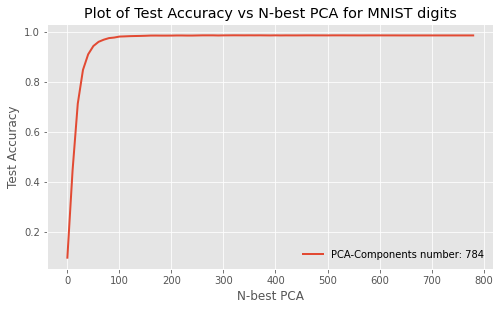

In [6]:
max_n = len(vals) #finding total number of components
fig,ax=plt.subplots(1,1, squeeze=False, figsize=(8,4.5)) #creating the figure for the different curves.
plot_acc_PCA(max_n, 5) #plotting the curve

## Plotting the curve using a model training on 100 components

We can then do the same, but for a CNN trained on a dataset with 100 best-principal components.

For 100 components, the time was 107 seconds


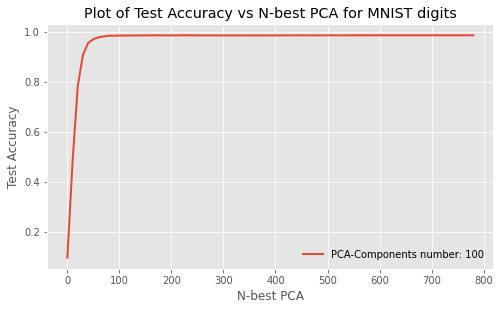

In [7]:
fig,ax=plt.subplots(1,1, squeeze=False, figsize=(8,4.5)) #creating the figure for the different curves.
plot_acc_PCA(100, 5)

## Plotting the curve using a model training on 20 components

Finally, we can do the same for 20-best PCA components.

For 20 components, the time was 108 seconds


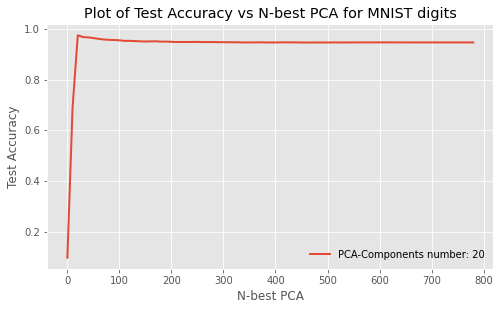

In [8]:
fig,ax=plt.subplots(1,1, squeeze=False, figsize=(8,4.5)) #creating the figure for the different curves.
plot_acc_PCA(20, 5)

To compare the three cases, I plotted them into a single plot. 

For 20 components, the time was 107 seconds
For 100 components, the time was 108 seconds
For 784 components, the time was 111 seconds


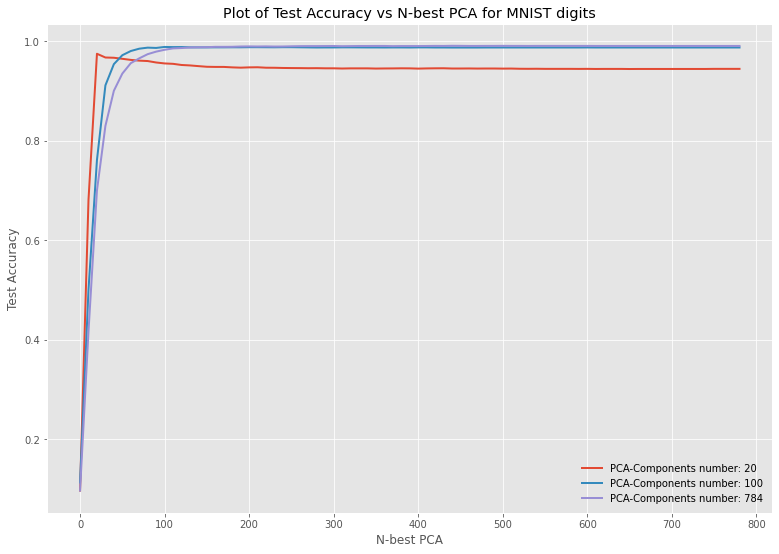

In [9]:
fig,ax=plt.subplots(1,1, squeeze=False, figsize=(13,9)) #creating the figure for the different curves.
for i in [20, 100, max_n]:
    plot_acc_PCA(i, 5)

By looking at this graph, we can make some important observations.

The model that was trained with all the PCA components behaved fairly regularly, steadily reaching the state of highest accuracy. 

The model trained with just 20 PCA components on the other hand very quickly reached a high accuracy, suggesting that it was trained at recognising very simple shapes (i.e. the digits when only 20 components are used) but it is not performing well when in the "real word", where each digit is in its 784 components form. 

The main surprise however is the model trained on 100 PCA components. This model in fact very quickly grows in test accuracy (similarly, but not as much as the 20-components one), but then, unlike the 20-components one, it does not fall in accuracy. Indeed, its accuracy stays approximately as high as in the model trained on the original dataset. This effectively mean that we are able to train a model on approximately 1/8 of the dimensions, and still obtain a perfectly similar result, while strongly reducing the dimensionality. 

So is there an optimal number of component for this specific task? let's investigate the curves a bit more and search for the right trade-off.

For 1 components, the time was 95 seconds
For 10 components, the time was 95 seconds
For 20 components, the time was 95 seconds
For 40 components, the time was 95 seconds
For 60 components, the time was 94 seconds
For 100 components, the time was 94 seconds
For 150 components, the time was 95 seconds
For 200 components, the time was 94 seconds
For 300 components, the time was 95 seconds
For 500 components, the time was 96 seconds
For 600 components, the time was 95 seconds
For 784 components, the time was 96 seconds


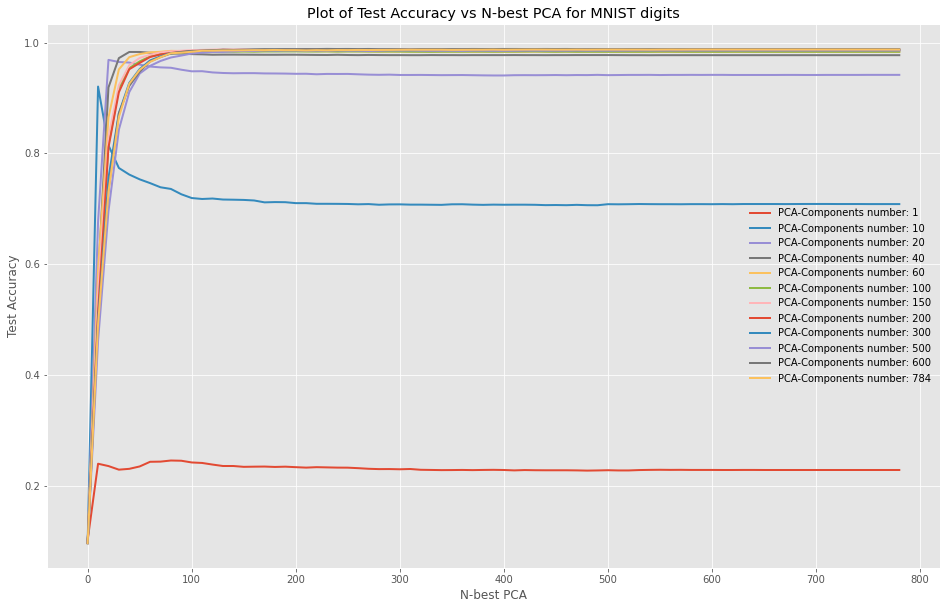

In [10]:
fig,ax=plt.subplots(1,1, squeeze=False, figsize=(16,10)) #creating the figure for the different curves.
components = [1, 10, 20, 40, 60, 100, 150, 200, 300, 500, 600, 784] #deciding on values of N components

for i in components:
    plot_acc_PCA(i, 2)

It does look like the model trained on 100 PCA-components is indeed the best one. The model traiend on 40-components could also be used, if one is more interested in dimensionality reduction over accuracy (since the reduction in accuracy is not tremendously high) but under normal circumstances the 100 PCA model delivers the best accuracy and dimensionality reduction trade-off.

Dimensionality reduction is an essential theme in Machine Learning, where a model's overfitting can be reduced by using dimensionality reduction. 